In [4]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display
import cv2
import glob

def load_and_strip(intensity_file_path):
    intensity_image = nib.load(intensity_file_path)
    affined = intensity_image.affine
    headered = intensity_image.header
    intensity_image = intensity_image.get_fdata()

    # Remove singleton dimensions
    intensity_image = np.squeeze(intensity_image)

    return intensity_image, affined, headered
def extract_numeric_part(filename):
    # Remove file extension
    base_filename, _ = os.path.splitext(filename)
    
    # Extract digits from the modified filename
    digits_only = ''.join(filter(str.isdigit, base_filename))
    
    # Return 0 if no digits are found, otherwise return the integer value
    return int(digits_only) if digits_only else 0

def calling_folders(label_propagation_path):
    label_propagation_files = {}
    patients = [d for d in os.listdir(label_propagation_path) if os.path.isdir(os.path.join(label_propagation_path, d))]

    for patient in patients:
        patient_path = os.path.join(label_propagation_path, patient)
        label_propagation_files[patient] = {}

        for tissue in ['csf', 'gm', 'wm']:
            tissue_file_pattern = os.path.join(patient_path, tissue, "result.nii")
            tissue_files = glob.glob(tissue_file_pattern)

            if tissue_files:
                result_path = tissue_files[0]
                label_propagation_files[patient][tissue] = result_path

    return label_propagation_files



def normalize(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) # scale the intensities between 0, 255
    img = img.astype(int)
    norm_skull_stripped = img.astype(np.float64)
    return norm_skull_stripped

def label_prop(img, csfs, gms, wms):

    image_bg = np.zeros(img.shape[0])
    stacked_ = np.stack((image_bg, csfs, gms, wms), axis=0)
    labels = np.argmax(stacked_, axis=0)
    return stacked_, labels


def plott(seg, gt):
    slice_index = 145
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(seg[:, :, slice_index], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Segmentation: Slice {slice_index}")
    # Plot the second image in the second subplot
    axs[1].imshow(gt[:, :, slice_index], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Ground truth: Slice {slice_index}")
    # Show the plot
    plt.show()

def dice_coefficient(im1, im2):
    intersection = np.sum(im1 * im2)
    dice = 2 * intersection / (np.sum(im1) + np.sum(im2))
    return dice

def compute_dice_for_tissues(im1, im2, label):
    seg = (im1 == label)
    gt = (im2 == label)
    return dice_coefficient(seg, gt)

def dice_coefficient_for_all_tissues(im1, im2):
    # Computing the dice coefficient for each tissue:
    dice_csf = compute_dice_for_tissues(im2, im1, 1)  # CSF
    dice_gm = compute_dice_for_tissues(im2, im1, 2)  # GM
    dice_wm = compute_dice_for_tissues(im2, im1, 3)  # WM

    return dice_csf, dice_gm, dice_wm

Saved segmentation for IBSR_13 at /Users/melikapooyan/Finalmisa(IBRS)/First.approach/seg.result/IBSR_13_segmentation.nii.gz
Dice coefficient for CSF: 0.531685492151973
Dice coefficient for GM: 0.8258683878626011
Dice coefficient for WM: 0.6554965700352539


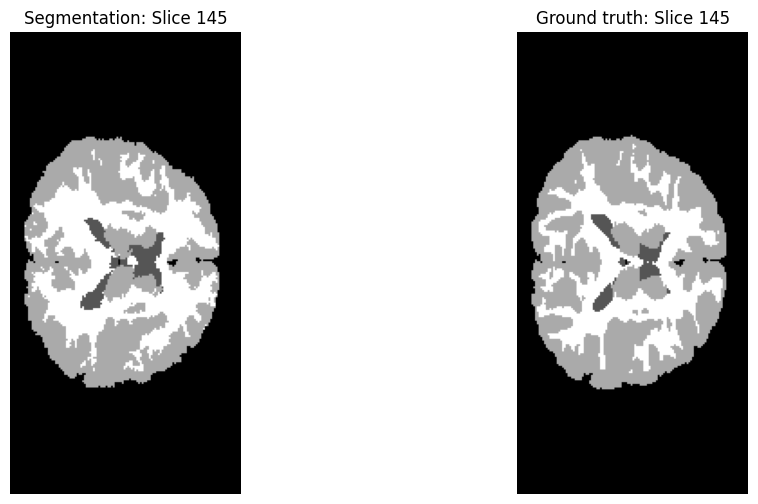

Saved segmentation for IBSR_14 at /Users/melikapooyan/Finalmisa(IBRS)/First.approach/seg.result/IBSR_14_segmentation.nii.gz
Dice coefficient for CSF: 0.5478376777251185
Dice coefficient for GM: 0.7912722001580942
Dice coefficient for WM: 0.6779300839071716


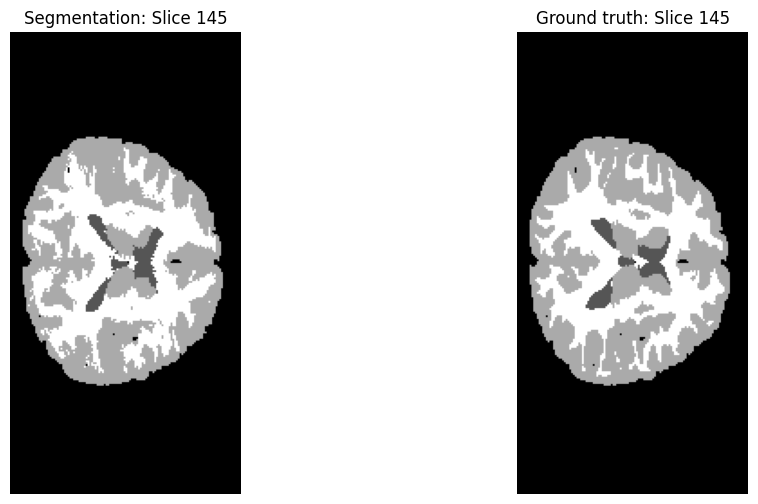


Mean Dice Coefficient for each tissue type:
Tissue 1 Mean Dice: 0.54
Tissue 2 Mean Dice: 0.81
Tissue 3 Mean Dice: 0.67


In [6]:

# Directory to save segmentation results
output_base_dir = '/Users/melikapooyan/Finalmisa(IBRS)/First.approach/seg.result'

# Initialize a dictionary to store Dice coefficients for each tissue type
tissue_dice = {1: [], 2: [], 3: []}  # 1: CSF, 2: GM, 3: WM

folders = ['13', '14']
base_path = '/Users/melikapooyan/Documents/elastix-5.0/Misa.course/TVTSets/validation_Set'
label_propagation_path = '/Users/melikapooyan/Documents/elastix-5.0/Misa.course/First_approach/Scanner1/atlas1'

label_propagation_files = calling_folders(label_propagation_path)

for folder, (patient, tissues) in zip(folders, label_propagation_files.items()):
    # Constructing file paths
    intens_path = os.path.join(base_path, f'IBSR_{folder}', f'IBSR_{folder}.nii.gz')
    gt_path = os.path.join(base_path, f'IBSR_{folder}', f'IBSR_{folder}_seg.nii.gz')

    # Load images
    intens_img, affined, headered = load_and_strip(intens_path)
    gt_labels = nib.load(gt_path).get_fdata()



    images_intensities = []
    brain_mask = (gt_labels != 0)
    brain_mask = np.squeeze(brain_mask)

    intens_img_1d = intens_img[brain_mask] 
    images_intensities.append(intens_img_1d)
    images_intensities_t = np.asarray(images_intensities).transpose(1, 0)

    csfs = gms = wms = None

    if 'csf' in tissues:
        csfs = nib.load(tissues['csf']).get_fdata()[brain_mask]
    if 'gm' in tissues:
        gms = nib.load(tissues['gm']).get_fdata()[brain_mask]
    if 'wm' in tissues:
        wms = nib.load(tissues['wm']).get_fdata()[brain_mask]

        # print(csfs.shape)
        # print(gms.shape)
        # print(wms.shape)
        # print(images_intensities_t.shape)


        _, labels = label_prop(images_intensities_t, csfs, gms, wms)

        # Reshape labels to match the shape of the indexing result
        labels_reshaped = labels[:, np.newaxis]

        image_shape = gt_labels.shape
        final_cluster_assignments = np.zeros(image_shape, dtype=int)

        final_cluster_assignments[brain_mask] = labels_reshaped

        segmentation_map = final_cluster_assignments.reshape(image_shape)
        
        # evaluate with Dice:
        dice1, dice2, dice3 = dice_coefficient_for_all_tissues(segmentation_map, gt_labels)
        #print(os.path.basename(intensities_path))

        # Ensure output directory exists
        if not os.path.exists(output_base_dir):
            os.makedirs(output_base_dir)

        # Save the segmentation result
        output_path = os.path.join(output_base_dir, f'IBSR_{folder}_segmentation.nii.gz')
        nib.save(nib.Nifti1Image(segmentation_map, affined, headered), output_path)

        print(f"Saved segmentation for IBSR_{folder} at {output_path}")


        # Print the results:
        print("Dice coefficient for CSF:", dice1)
        print("Dice coefficient for GM:", dice2)
        print("Dice coefficient for WM:", dice3)

        plott(segmentation_map, gt_labels)
            # Evaluate with Dice:
        dice1, dice2, dice3 = dice_coefficient_for_all_tissues(segmentation_map, gt_labels)

    # Append Dice coefficients to the corresponding lists
    tissue_dice[1].append(dice1)
    tissue_dice[2].append(dice2)
    tissue_dice[3].append(dice3)

# Calculate and print the mean Dice coefficient for each tissue
print("\nMean Dice Coefficient for each tissue type:")
for tissue_type in tissue_dice:
    mean_dice = np.mean(tissue_dice[tissue_type])
    print(f"Tissue {tissue_type} Mean Dice: {mean_dice:.2f}")

In [ ]:
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import os

def load_nifti(file_path):
    """Load a NIfTI file and return a NumPy array, affine and header."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata(), nifti_image.affine, nifti_image.header

import SimpleITK as sitk
import numpy as np

def sitk_like(np_array, reference_sitk_img):
    """Convert a NumPy array to a SimpleITK Image, matching the reference image."""
    sitk_img = sitk.GetImageFromArray(np_array)
    sitk_img.CopyInformation(reference_sitk_img)
    return sitk_img

def compute_hausdorff(groundT, segmentation, reference_sitk):
    """Compute Hausdorff distance between ground truth and segmentation."""
    HD_distances = []

    # Adjust the check for single-channel images
    if groundT.ndim == 4 and groundT.shape[-1] == 1:
        groundT = groundT[..., 0]
    if segmentation.ndim == 4 and segmentation.shape[-1] == 1:
        segmentation = segmentation[..., 0]

    if groundT.ndim != 3 or segmentation.ndim != 3:
        raise ValueError("Input images must be single-channel (grayscale) and 3D.")

    for tissue in range(1, 4):  # Assuming three tissues are labeled as 1, 2, and 3
        # Convert images to SimpleITK format
        groundT_tissue = (groundT == tissue).astype(np.uint8)
        groundT_tissue_sitk = sitk_like(groundT_tissue, reference_sitk)
        segmentation_tissue = (segmentation == tissue).astype(np.uint8)
        segmentation_tissue_sitk = sitk_like(segmentation_tissue, reference_sitk)

        # Define the Hausdorff distance filter
        hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

        # Compute distance
        hausdorff_distance_filter.Execute(groundT_tissue_sitk, segmentation_tissue_sitk)
        distance = hausdorff_distance_filter.GetHausdorffDistance()

        # Append to list
        HD_distances.append(distance)

    return HD_distances


# Tissue name mapping
tissue_names = {1: 'CSF', 2: 'GM', 3: 'WM'}

if __name__ == "__main__":
    validation_cases = ['11', '12', '13', '14', '17']
    base_dir = '/Users/melikapooyan/Documents/elastix-5.0/Misa.course/IBSR/Validation_Set'
    seg_dir = '/Users/melikapooyan/Finalmisa(IBRS)/Second.approach/seg.result'

    # Initialize a dictionary to store Hausdorff distances for each tissue type
    tissue_hd = {1: [], 2: [], 3: []}

    for case in validation_cases:
        groundT_path = os.path.join(base_dir, f'IBSR_{case}', f'IBSR_{case}_seg.nii.gz')
        segmentation_path = os.path.join(seg_dir, f'IBSR_{case}_segmented.nii.gz')

        # Load ground truth and segmentation
        groundT, affine, _ = load_nifti(groundT_path)
        segmentation, _, _ = load_nifti(segmentation_path)

        # Use the ground truth as the reference SimpleITK image
        reference_sitk_image = sitk.GetImageFromArray(groundT.astype(np.uint8))
        reference_sitk_image.SetSpacing((affine[0,0], affine[1,1], affine[2,2]))

        # Compute Hausdorff distances
        hausdorff_distances = compute_hausdorff(groundT, segmentation, reference_sitk_image)

        # Print Hausdorff distances for the current case
        print(f"Case IBSR_{case}:")
        for tissue_type, hd in enumerate(hausdorff_distances, start=1):
            print(f"  {tissue_names[tissue_type]} Hausdorff Distance: {hd}")
            tissue_hd[tissue_type].append(hd)

    # Calculate and print the mean Hausdorff distance for each tissue
    print("\nMean Hausdorff Distance for each tissue type:")
    for tissue_type, distances in tissue_hd.items():
        mean_hd = np.mean(distances)
        print(f"  {tissue_names[tissue_type]}: {mean_hd}")

In [8]:
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import os

def load_nifti(file_path):
    """Load a NIfTI file and return a NumPy array, affine and header."""
    nifti_image = nib.load(file_path)
    return nifti_image.get_fdata(), nifti_image.affine, nifti_image.header

import SimpleITK as sitk
import numpy as np

def sitk_like(np_array, reference_sitk_img):
    """Convert a NumPy array to a SimpleITK Image, matching the reference image."""
    sitk_img = sitk.GetImageFromArray(np_array)
    sitk_img.CopyInformation(reference_sitk_img)
    return sitk_img

def compute_hausdorff(groundT, segmentation, reference_sitk):
    """Compute Hausdorff distance between ground truth and segmentation."""
    HD_distances = []

    # Adjust the check for single-channel images
    if groundT.ndim == 4 and groundT.shape[-1] == 1:
        groundT = groundT[..., 0]
    if segmentation.ndim == 4 and segmentation.shape[-1] == 1:
        segmentation = segmentation[..., 0]

    if groundT.ndim != 3 or segmentation.ndim != 3:
        raise ValueError("Input images must be single-channel (grayscale) and 3D.")

    for tissue in range(1, 4):  # Assuming three tissues are labeled as 1, 2, and 3
        # Convert images to SimpleITK format
        groundT_tissue = (groundT == tissue).astype(np.uint8)
        groundT_tissue_sitk = sitk_like(groundT_tissue, reference_sitk)
        segmentation_tissue = (segmentation == tissue).astype(np.uint8)
        segmentation_tissue_sitk = sitk_like(segmentation_tissue, reference_sitk)

        # Define the Hausdorff distance filter
        hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()

        # Compute distance
        hausdorff_distance_filter.Execute(groundT_tissue_sitk, segmentation_tissue_sitk)
        distance = hausdorff_distance_filter.GetHausdorffDistance()

        # Append to list
        HD_distances.append(distance)

    return HD_distances


# Tissue name mapping
tissue_names = {1: 'CSF', 2: 'GM', 3: 'WM'}

# Initialize a dictionary to store Hausdorff distances for each tissue type
tissue_hd = {1: [], 2: [], 3: []}

validation_cases = ['13', '14']
base_dir = '/Users/melikapooyan/Documents/elastix-5.0/Misa.course/TVTSets/Validation_Set'
seg_dir = '/Users/melikapooyan/Finalmisa(IBRS)/First.approach/seg.result'

for case in validation_cases:
    groundT_path = os.path.join(base_dir, f'IBSR_{case}', f'IBSR_{case}_seg.nii.gz')
    segmentation_path = os.path.join(seg_dir, f'IBSR_{case}_segmentation.nii.gz')

    # Load ground truth and segmentation
    groundT, affine, _ = load_nifti(groundT_path)
    segmentation, _, _ = load_nifti(segmentation_path)

    # Use the ground truth as the reference SimpleITK image
    reference_sitk_image = sitk.GetImageFromArray(groundT.astype(np.uint8))
    reference_sitk_image.SetSpacing((affine[0,0], affine[1,1], affine[2,2]))

    # Compute Hausdorff distances
    hausdorff_distances = compute_hausdorff(groundT, segmentation, reference_sitk_image)

    # Print and append Hausdorff distances for the current case
    print(f"Case IBSR_{case}:")
    for tissue_type, hd in enumerate(hausdorff_distances, start=1):
        print(f"  {tissue_names[tissue_type]} Hausdorff Distance: {hd}")
        tissue_hd[tissue_type].append(hd)

# Calculate and print the mean Hausdorff distance for each tissue
print("\nMean Hausdorff Distance for each tissue type:")
for tissue_type, distances in tissue_hd.items():
    mean_hd = np.mean(distances)
    print(f"  {tissue_names[tissue_type]} Mean Hausdorff Distance: {mean_hd:.2f}")


Case IBSR_13:
  CSF Hausdorff Distance: 11.93242693252299
  GM Hausdorff Distance: 11.443645889750346
  WM Hausdorff Distance: 13.42295724682158
Case IBSR_14:
  CSF Hausdorff Distance: 26.59659576430788
  GM Hausdorff Distance: 9.604686356149273
  WM Hausdorff Distance: 16.129359875704925

Mean Hausdorff Distance for each tissue type:
  CSF Mean Hausdorff Distance: 19.26
  GM Mean Hausdorff Distance: 10.52
  WM Mean Hausdorff Distance: 14.78
